# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


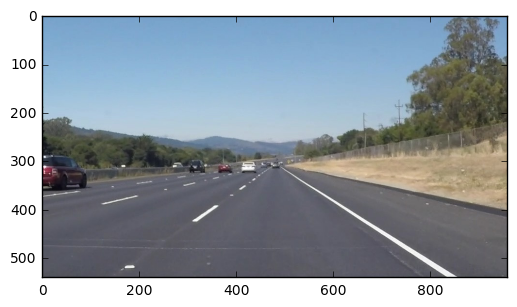

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

Image  test_images/solidWhiteCurve.jpg  has dimensions:  (540, 960, 3)  with line_info:  (-0.24325551249821253, -0.80922589670310341, 0.56597038420489088, 418, 562)
Image  test_images/solidWhiteRight.jpg  has dimensions:  (540, 960, 3)  with line_info:  (-0.081157372550989204, -0.7161793372319688, 0.6350219646809796, 413, 556)
Image  test_images/solidYellowCurve.jpg  has dimensions:  (540, 960, 3)  with line_info:  (-0.15848360806348138, -0.71149074363942433, 0.55300713557594294, 419, 544)
Image  test_images/solidYellowCurve2.jpg  has dimensions:  (540, 960, 3)  with line_info:  (-0.15182377962266946, -0.73993151657086087, 0.58810773694819141, 416, 549)
Image  test_images/solidYellowLeft.jpg  has dimensions:  (540, 960, 3)  with line_info:  (-0.090080395773692645, -0.70228181922836108, 0.61220142345466844, 411, 551)
Image  test_images/whiteCarLaneSwitch.jpg  has dimensions:  (540, 960, 3)  with line_info:  (-0.17897031425141718, -0.76641074136725473, 0.58744042711583755, 424, 558)


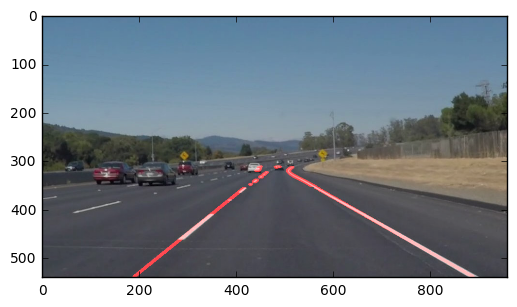

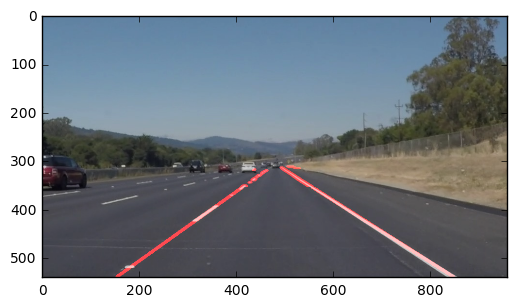

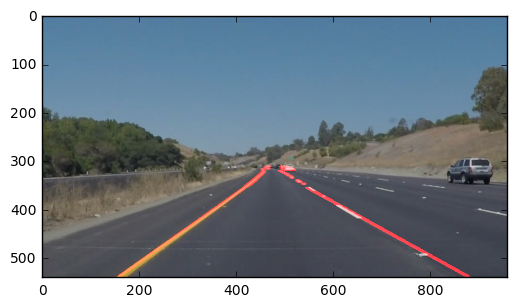

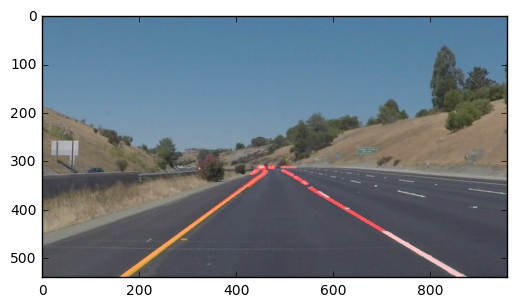

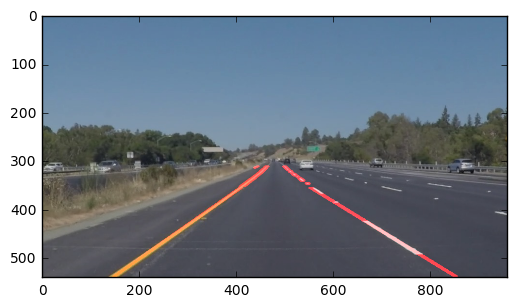

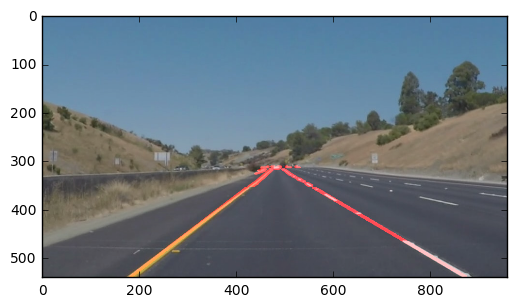

In [4]:
# fifth attempt
#   This version tries to do the same thing as version three and four, but
#   put some more intelligence in passing information from the first case
#   to middle case, also add more intelligence in sorting the line segments
#   in the middle case:
#   Third attempt at Optional Challenge

# swap points in line segment - needed for ordering line segments
def swappoints(x1, y1, x2, y2):
    return (x2, y2, x1, y1)

# some functions for debugging
def my_draw_bounding_box(img, boundingbox, color=[0,255,0], thickness=2):
    x1, y1, x2, y2 = boundingbox
    cv2.line(img, (x1, y1), (x2, y1), color, thickness)
    cv2.line(img, (x2, y1), (x2, y2), color, thickness)
    cv2.line(img, (x2, y2), (x1, y2), color, thickness)
    cv2.line(img, (x1, y2), (x1, y1), color, thickness)

def my_draw_masked_area(img, areas, color=[128,0,128], thickness=2):
    for points in areas:
        for i in range(len(points)-1):
            cv2.line(img, (points[i][0], points[i][1]), (points[i+1][0],points[i+1][1]), color, thickness)
        cv2.line(img, (points[0][0], points[0][1]), (points[len(points)-1][0],points[len(points)-1][1]), color, thickness)

# some functions to help locate yellow and white lines - especially against concrete
def my_image_only_yellow_white_curve(image):
    # setup inRange to mask off everything except white and yellow
    lower_yellow_white = np.array([162, 16, 16])
    upper_yellow_white = np.array([255, 255, 255])
    mask = cv2.inRange(image, lower_yellow_white, upper_yellow_white)
    return cv2.bitwise_and(image, image, mask=mask)

def my_image_only_yellow_white_curve2(image):
    # setup inRange to mask off everything except white and yellow
    lower_yellow_white = np.array([140, 140, 64])
    upper_yellow_white = np.array([255, 255, 255])
    mask = cv2.inRange(image, lower_yellow_white, upper_yellow_white)
    return cv2.bitwise_and(image, image, mask=mask)

def my_image_only_yellow_white_curve3(image):
    # setup inRange to mask off everything except white and yellow
    lower_yellow_white = np.array([192, 192, 32])
    upper_yellow_white = np.array([255, 255, 255])
    mask = cv2.inRange(image, lower_yellow_white, upper_yellow_white)
    return cv2.bitwise_and(image, image, mask=mask)

def my_draw_lines_mid5(img, lines, color=[255, 0, 0], thickness=6):
    ysize = img.shape[0]
    try:
        # rightline and leftline cumlators
        rl = {'num':0, 'slope':0.0, 'x1':0, 'y1':0, 'x2':0, 'y2':0}
        ll = {'num':0, 'slope':0.0, 'x1':0, 'y1':0, 'x2':0, 'y2':0}
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = ((y2-y1)/(x2-x1))
                if slope > 0.5 and slope < 1.0:   # right
                    rl['num'] += 1
                    rl['slope'] += slope
                    rl['x1'] += x1
                    rl['y1'] += y1
                    rl['x2'] += x2
                    rl['y2'] += y2
                elif slope > -1.0 and slope < -0.5:   # left
                    ll['num'] += 1
                    ll['slope'] += slope
                    ll['x1'] += x1
                    ll['y1'] += y1
                    ll['x2'] += x2
                    ll['y2'] += y2

        if rl['num'] > 0 and ll['num'] > 0:
            # average/extrapolate all of the lines that makes the right line
            rslope = rl['slope']/rl['num']
            rx1 = int(rl['x1']/rl['num'])
            ry1 = int(rl['y1']/rl['num'])
            rx2 = int(rl['x2']/rl['num'])
            ry2 = int(rl['y2']/rl['num'])

            # average/extrapolate all of the lines that makes the left line
            lslope = ll['slope']/ll['num']
            lx1 = int(ll['x1']/ll['num'])
            ly1 = int(ll['y1']/ll['num'])
            lx2 = int(ll['x2']/ll['num'])
            ly2 = int(ll['y2']/ll['num'])

            # find the right and left line's intercept, which means solve the following two equations
            # rslope = ( yi - ry1 )/( xi - rx1)
            # lslope = ( yi = ly1 )/( xi - lx1)
            # solve for (xi, yi): the intercept of the left and right lines
            # which is:  xi = (ly2 - ry2 + rslope*rx2 - lslope*lx2)/(rslope-lslope)
            # and        yi = ry2 + rslope*(xi-rx2)
            xi = int((ly2 - ry2 + rslope*rx2 - lslope*lx2)/(rslope-lslope))
            yi = int(ry2 + rslope*(xi-rx2))

        # calculate backoff from intercept for right line
        if rslope > 0.5 and rslope < 1.0:   # right
            #ry1 = yi + thickness*2
            #rx1 = int(rx2-(ry2-ry1)/rslope)
            #ry2 = ysize-1
            #rx2 = int(rx1+(ry2-ry1)/rslope)
            cv2.line(img, (rx1, ry1), (rx2, ry2), [255, 0, 0], thickness)

        # calculate backoff from intercept for left line
        if lslope < -0.5 and lslope > -1.0:   # left
            #ly1 = yi + thickness*2
            #lx1 = int(lx2-(ly2-ly1)/lslope)
            #ly2 = ysize-1
            #lx2 = int(lx1+(ly2-ly1)/lslope)
            cv2.line(img, (lx1, ly1), (lx2, ly2), [255, 0, 0], thickness)

        return rslope+lslope, lslope, rslope, rx1, lx1
    except:
        return -1000.00, 0.0, 0.0, 0, 0

def my_hough_lines_mid5(img, rho, theta, threshold, min_line_len, max_line_gap, top, debug=False):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn using the new single line for left and right lane line method.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

    # Create a "color" binary image to combine with original image
    ignore_color = np.copy(img)*0 # creating a blank color channel for combining
    line_img = np.dstack((ignore_color, ignore_color, ignore_color))

    if debug:
        masked_img = np.copy(img)
        line_img = np.dstack((masked_img, masked_img, masked_img))

    original_image = np.copy(line_img)
    try:
        draw_lines(line_img, lines, thickness=30)
        if np.array_equal(line_img, original_image) == True:
            lane_info = (-1000, 0.0, 0.0, 0, 0)
        else:
            lane_info = (0.0, 0.0, 0.0, 0, 0)
    except:
        lane_info = my_draw_lines_mid5(line_img, lines, thickness=30, debug=debug)

    return line_img, lane_info

def procmiddleimage5(image, leftx, rightx, debug=False):
    # mask calculations
    imshape = image.shape
    xbottom1 = leftx - int(imshape[1]/32)
    xbottom2 = rightx + int(imshape[1]/32)
    xtop1 = leftx + int(imshape[1]/8)
    xtop2 = rightx - int(imshape[1]/8)
    ybottom1 = imshape[0]
    ybottom2 = imshape[0]
    ytop1 = int(imshape[0]*16/32)
    ytop2 = int(imshape[0]*16/32)
   
    # Read in the image and convert to grayscale
    gray = grayscale(my_image_only_yellow_white_curve2(image))
   
    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 13 # Must be an odd number (3, 5, 7...)
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and run it
    low_threshold = 10
    high_threshold = 36
    edges = canny(blur_gray, low_threshold, high_threshold)
   
    # This time we are defining a four sided polygon to mask
    # We can lift the mask higher now, since the line drawing function is a bit smarter
    vertices = np.array([[(xbottom1,ybottom1),(xtop1, ytop1), (xtop2, ytop2), (xbottom2,ybottom2)]], dtype=np.int32)
    # vertices = np.array([[(xbottom1,ybottom1),(xbottom1, int(imshape[0]/2)), (xbottom2, int(imshape[0]/2)), (xbottom2,ybottom2)]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    line_image = np.dstack((masked_edges, masked_edges, masked_edges))
    #line_image = np.dstack((masked_edges, blur_gray, blur_gray))
    #my_draw_masked_area(line_image, vertices)
    #return line_image, (-1000, 0, 0, 0, 0)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments

    # Run Hough on edge detected image
    # Output "masked_lines" is a single channel mask
    line_image, lane_info = my_hough_lines_mid5(masked_edges, rho, theta, threshold, min_line_length, max_line_gap, ytop1, debug)

    if lane_info[0] == -1000:
        # Read in the image and convert to grayscale
        gray = grayscale(my_image_only_yellow_white_curve3(image))

        # Define a kernel size for Gaussian smoothing / blurring
        kernel_size = 11 # Must be an odd number (3, 5, 7...)
        blur_gray = gaussian_blur(gray, kernel_size)

        # Define our parameters for Canny and run it
        low_threshold = 5
        high_threshold = 17
        edges = canny(blur_gray, low_threshold, high_threshold)

        masked_edges = region_of_interest(edges, vertices)
        line_image = np.dstack((masked_edges, blur_gray, blur_gray))
        my_draw_masked_area(line_image, vertices)
        # return line_image, (-1000,0,0,0,0)

        # Define the Hough transform parameters
        # Make a blank the same size as our image to draw on
        rho = 1 # distance resolution in pixels of the Hough grid
        theta = np.pi/180 # angular resolution in radians of the Hough grid
        threshold = 30     # minimum number of votes (intersections in Hough grid cell)
        min_line_length = 20 #minimum number of pixels making up a line
        max_line_gap = 70    # maximum gap in pixels between connectable line segments
        line_image, lane_info = my_hough_lines_mid5(masked_edges, rho, theta, threshold, min_line_length, max_line_gap, ytop1, debug)

    if debug:
        my_draw_masked_area(line_image, vertices)

    # Create a "color" binary image to combine with original image
    #ignore_color = np.copy(masked_lines)*0 # creating a blank color channel for combining
    #line_image = np.dstack((masked_lines, ignore_color, ignore_color))

    # return the merged red colored lines with the image as background
    if debug:
        return weighted_img(line_image, image), lane_info
    return line_image, lane_info



# calculate average right line
def average_rightline(lines):
    # rightline cumlators
    rl = {'num':0, 'slope':0.0, 'x1':0, 'y1':0, 'x2':0, 'y2':0}

    try:
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = ((y2-y1)/(x2-x1))
                if slope > 0.5 and slope < 1.0:   # right
                    rl['num'] += 1
                    rl['slope'] += slope
                    rl['x1'] += x1
                    rl['y1'] += y1
                    rl['x2'] += x2
                    rl['y2'] += y2

        if rl['num'] > 0:
            # average/extrapolate all of the lines that makes the right line
            rslope = rl['slope']/rl['num']
            rx1 = int(rl['x1']/rl['num'])
            ry1 = int(rl['y1']/rl['num'])
            rx2 = int(rl['x2']/rl['num'])
            ry2 = int(rl['y2']/rl['num'])
            return rslope, rl['num'], rx1, ry1, rx2, ry2
        else:
            return -1000, 0, 0, 0, 0, 0
    except:
        return -1000, 0, 0, 0, 0, 0

def average_leftline(lines):
    # leftline cumlators
    ll = {'num':0, 'slope':0.0, 'x1':0, 'y1':0, 'x2':0, 'y2':0}

    try:
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = ((y2-y1)/(x2-x1))
                if slope > -1.0 and slope < -0.5:   # left
                    ll['num'] += 1
                    ll['slope'] += slope
                    ll['x1'] += x1
                    ll['y1'] += y1
                    ll['x2'] += x2
                    ll['y2'] += y2

        if ll['num'] > 0:
            # average/extrapolate all of the lines that makes the left line
            lslope = ll['slope']/ll['num']
            lx1 = int(ll['x1']/ll['num'])
            ly1 = int(ll['y1']/ll['num'])
            lx2 = int(ll['x2']/ll['num'])
            ly2 = int(ll['y2']/ll['num'])
            return lslope, ll['num'], lx1, ly1, lx2, ly2
        else:
            return -1000, 0, 0, 0, 0, 0
    except:
        return -1000, 0, 0, 0, 0, 0

# main line drawing routine for the big picture.
def my_draw_mainlines5(img, lines, ytop, color=[255, 0, 0], thickness=6, debug=False):
    ysize = img.shape[0]
    xsize = img.shape[1]
    rr1 = average_rightline(lines)
    # print("rr1: ", rr1)
    ll1 = average_leftline(lines)
    # print("ll1: ",ll1)

    try:
        # rightline and leftline cumlators
        rl = {'num':0, 'slope':0.0, 'x1':0, 'y1':0, 'x2':0, 'y2':0}
        ll = {'num':0, 'slope':0.0, 'x1':0, 'y1':0, 'x2':0, 'y2':0}
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = ((y2-y1)/(x2-x1))
                if slope > 0.5 and slope < 1.0:   # right
                    if (((slope-rr1[0])*(slope-rr1[0])) < 0.2) or rr1[1] < 3:
                    #if True:
                        rl['num'] += 1
                        rl['slope'] += slope
                        rl['x1'] += x1
                        rl['y1'] += y1
                        rl['x2'] += x2
                        rl['y2'] += y2
                    #else:
                    #    print("bad: right slope1: ",rr1[0]," to slope2: ", slope)
                elif slope > -1.0 and slope < -0.5:   # left
                    if ((slope-ll1[0])*(slope-ll1[0])) < 0.2 or ll1[1] < 3:
                    #if True:
                        ll['num'] += 1
                        ll['slope'] += slope
                        ll['x1'] += x1
                        ll['y1'] += y1
                        ll['x2'] += x2
                        ll['y2'] += y2
                    #else:
                    #    print("bad: left slope1: ",ll1[0]," to slope2: ", slope)


        if rl['num'] > 0 and ll['num'] > 0:
            # average/extrapolate all of the lines that makes the right line
            rslope = rl['slope']/rl['num']
            rx1 = int(rl['x1']/rl['num'])
            ry1 = int(rl['y1']/rl['num'])
            rx2 = int(rl['x2']/rl['num'])
            ry2 = int(rl['y2']/rl['num'])

            # average/extrapolate all of the lines that makes the left line
            lslope = ll['slope']/ll['num']
            lx1 = int(ll['x1']/ll['num'])
            ly1 = int(ll['y1']/ll['num'])
            lx2 = int(ll['x2']/ll['num'])
            ly2 = int(ll['y2']/ll['num'])

            # find the right and left line's intercept, which means solve the following two equations
            # rslope = ( yi - ry1 )/( xi - rx1)
            # lslope = ( yi = ly1 )/( xi - lx1)
            # solve for (xi, yi): the intercept of the left and right lines
            # which is:  xi = (ly2 - ry2 + rslope*rx2 - lslope*lx2)/(rslope-lslope)
            # and        yi = ry2 + rslope*(xi-rx2)
            xi = int((ly2 - ry2 + rslope*rx2 - lslope*lx2)/(rslope-lslope))
            yi = int(ry2 + rslope*(xi-rx2))

            # calculate backoff from intercept for right line
            if rslope > 0.5 and rslope < 1.0:   # right
                ry1 = ytop
                rx1 = int(rx2-(ry2-ry1)/rslope)
                ry2 = ysize-1
                rx2 = int(rx1+(ry2-ry1)/rslope)
                cv2.line(img, (rx1, ry1), (rx2, ry2), [255, 0, 0], thickness)

            # calculate backoff from intercept for left line
            if lslope < -0.5 and lslope > -1.0:   # left
                ly1 = ytop
                lx1 = int(lx2-(ly2-ly1)/lslope)
                ly2 = ysize-1
                lx2 = int(lx1+(ly2-ly1)/lslope)
                cv2.line(img, (lx1, ly1), (lx2, ly2), [255, 0, 0], thickness)

            # if the intercept is in bounding box - then we did not do it right, reject the solution
            if yi > ytop:
                return -1000, 0.0, 0.0, 0.0, 0, 0

        return lslope+rslope, lslope, rslope, lx1, rx1
    except:
        return -1000, 0.0, 0.0, 0.0, 0, 0


# main hough logic for the main picture
def my_hough_mainlines5(img, rho, theta, threshold, min_line_len, max_line_gap, ytop, debug=False):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    ignore_color = np.zeros(img.shape, dtype=np.uint8)
    masked_lines = np.zeros(img.shape, dtype=np.uint8)
    line_info = my_draw_mainlines5(masked_lines, lines, ytop)
    line_image = np.dstack((masked_lines, ignore_color, ignore_color))
    if debug:
        line_image = np.dstack((masked_lines, img, img))

    return line_image, line_info

# main process for doing the lane finding.  It splits it into two seperate tasks:
# 1. Main picture, with the middle section clipped.
# 2. The middle section, where curves maybe at and needs special detections.
def procimage5(image, debug=False):
    # mask calculations
    imshape = image.shape
    xbottom1 = int(imshape[1]/16)
    xbottom2 = int(imshape[1]*15/16)
    xtop1 = int(imshape[1]*6/16)
    xtop2 = int(imshape[1]*10/16)
    ybottom1 = imshape[0]
    ybottom2 = imshape[0]
    ytop1 = int(imshape[0]*21/32)
    ytop2 = int(imshape[0]*21/32)
    ytopbox = int(imshape[0]*8/16)

    # Read in the image and convert to grayscale
    gray = grayscale(my_image_only_yellow_white_curve3(image))

    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 11 # Must be an odd number (3, 5, 7...)
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and run it
    low_threshold = 5
    high_threshold = 17
    edges = canny(blur_gray, low_threshold, high_threshold)

    # This time we are defining a four sided polygon to mask
    # We can lift the mask higher now, since the line drawing function is a bit smarter
    vertices = np.array([[(xbottom1,ybottom1),(xtop1, ytop1), (xtop2, ytop2), (xbottom2,ybottom2)]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    #bounding box for next iteration candidate
    boundingbox = (xtop1, ytop1, xtop2, ytopbox)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 30     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 75 #150 #minimum number of pixels making up a line
    max_line_gap = 100 #150    # maximum gap in pixels between connectable line segments

    # Run Hough on edge detected image
    # Output "masked_lines" is a single channel mask
    line_image, lane_info = my_hough_mainlines5(masked_edges, rho, theta, threshold, min_line_length, max_line_gap, ytop1, debug)

    # The first attempt at getting lines did not work if we get a -1000 slope, lets try again with a different yellow/white setting
    if lane_info[0] == -1000:
        # Read in the image and convert to grayscale
        gray = grayscale(my_image_only_yellow_white_curve2(image))

        # Define a kernel size for Gaussian smoothing / blurring
        kernel_size = 13 # Must be an odd number (3, 5, 7...)
        blur_gray = gaussian_blur(gray, kernel_size)

        # Define our parameters for Canny and run it
        low_threshold = 10
        high_threshold = 36
        edges = canny(blur_gray, low_threshold, high_threshold)
        masked_edges = region_of_interest(edges, vertices)


        # Define the Hough transform parameters
        # Make a blank the same size as our image to draw on
        rho = 1 # distance resolution in pixels of the Hough grid
        theta = np.pi/180 # angular resolution in radians of the Hough grid
        threshold = 30     # minimum number of votes (intersections in Hough grid cell)
        min_line_length = 50 #minimum number of pixels making up a line
        max_line_gap = 75    # maximum gap in pixels between connectable line segments
        line_image, lane_info = my_hough_mainlines5(masked_edges, rho, theta, threshold, min_line_length, max_line_gap, ytop1, debug)

    # draw some debugging lines if we are in debugging mode...
    if debug:
        my_draw_masked_area(line_image, vertices)
        my_draw_bounding_box(line_image, boundingbox)

    # cropped the center image and resize to the same size as the original if we could get lines out!
    if not (lane_info[0] == -1000):
        # save the old dimensions of the middle crop - we are going to resize for better line pickup
        olddim = ((xtop2-xtop1), (ytop1-ytopbox))

        # it is a small strip, so we better expand it by 4 times wide and 8 times tall.
        dim = ((xtop2-xtop1)*4, (ytop1-ytopbox)*8)
        cropped_image = image[ytopbox:ytop1, xtop1:xtop2]
        resized_cropped_image = cv2.resize(cropped_image, dim, interpolation=cv2.INTER_AREA)

        # call the procmiddleimage5 function to do the middle image processing
        middle_line_image, middle_lane_info = procmiddleimage5(resized_cropped_image, (lane_info[3]-xtop1)*4, (lane_info[4]-xtop1)*4, debug)

        # drop the line image back to where it should be.
        resized_cropped_image = cv2.resize(middle_line_image, olddim, interpolation=cv2.INTER_AREA)
        line_image[ytopbox:ytop1, xtop1:xtop2] = resized_cropped_image

    # return the merged red colored lines with the image as background
    return weighted_img(line_image, image), lane_info

# loop through and display all of the process images
import os
import re
filepath = "test_images/"
pattern = re.compile("^.+processed.jpg$")
files = os.listdir(filepath)
for file in files:
    # import the image if it is not a saved output
    if not pattern.match(file):
        image_filepath = filepath + file
        image = mpimg.imread(image_filepath)

        # process image
        image_wlines, line_info = procimage5(image)               # attempt 1
        print('Image ', image_filepath, ' has dimensions: ', image.shape, ' with line_info: ', line_info)

        # next image
        plt.figure()

        # plot the image
        plt.imshow(image_wlines)

        # writeout the image with "-processed" in the name so it will not be reprocessed.
        plt.savefig(image_filepath.replace(".jpg","-processed.jpg"))


run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    # attempt 1
    # result = procimage1(image)
    # attempt 2
    # result = procimage2(image)
    # attempt 3
    # result, lane_info = procimage3(image)
    # attempt 4
    # result, lane_info = procimage4(image)
    # attempt 5
    result, lane_info = procimage5(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:21<00:00,  9.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 13.8 s, sys: 2.43 s, total: 16.2 s
Wall time: 23.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [01:10<00:00,  8.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 43.8 s, sys: 7.43 s, total: 51.3 s
Wall time: 1min 12s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

**Response:**

Hi,

I would have submitted this project earlier if it was just case 1 and 2, but the curve lane with white concrete surface was quite a challenge!  After the second attempt, I was able to do case 1 and 2, but require another five attempts to get to this version, which uses *inRange* to better separate the yellow lane markers from the white concrete surface and at the same time uses a higher *rho* and *threshold* values for the **Hough Transform** line finding algorthm.

Hopefully, the code I submit will work most of the time for all cases.  I have to say that since I am just drawing a single straight line for each left and right side needs improvement.  The line fit seems to work correctly near the bottom of the picture for all cases, but fails dramatically at the horizon where the lane markings are faint.  A better algorthm for fitting curve lane markers would greatly improve this particular version that I am submitting.  I attempted to issolate the middle horizon section by clipping it and processing it separately by resizing it to a higher vertical resolution (version 4), but had to drop this approach since it became too complex and CPU intensive.  I placed all my Jupyter notebooks in an **attempts** subdirectory for you to examine if you are interested.

Although using the *inRange* and higher *rho* and *threshold* values works most of the time, there are still corner cases that causes the lane markings to be incorrectly identified.  Purhaps tuning the *inRange* in another color space would help.  Something to consider is to consider weighing the lines in such a way as to walk back up the lane markings and fill the missing lines as we travers the lines identified by the **Hough Transform** algorthm while ignoring lines not part of the lane markings.  Maybe use the algorthm with 0 minimum gap and fill those gaps ourselves to make a better curve fit?  Another algorthm to consider would be to order the lines output from the **Hough Transform** algorthm in such a way as to separate the lines that are part of the lane from objects on the road, such as other cars, white concrete surfaces, etc.  Use a *Machine Learning* algorthms purhaps?  Something to explore in the future!

## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [10]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:46<00:00,  6.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 27.1 s, sys: 5.72 s, total: 32.8 s
Wall time: 49.4 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))